In [ ]:
import os
import sys
import math
import json
import warnings
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_console

import numpy as np
import pandas as pd
import scipy
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, Sampler, WeightedRandomSampler
from torch.optim.lr_scheduler import _LRScheduler, LambdaLR

warnings.filterwarnings('ignore')

In [3]:
ann = pd.read_csv('/kaggle/input/slovo/annotations.csv', sep='\t')

classes_text = ann['text'].unique()[:500]
ann = ann[ann['text'].isin(classes_text)]

ann['sign_ord'] = ann['text'].astype('category').cat.codes

def get_parquet_path(row):
    if row['train']:
        return f'/kaggle/input/mediapipe-parquet/SBER2/train/{row["attachment_id"]}.parquet'
    else:
        return f'/kaggle/input/mediapipe-parquet/SBER2/test/{row["attachment_id"]}.parquet'

def get_video_path(row):
    if row['train']:
        return f'/kaggle/input/slovo/slovo/train/{row["attachment_id"]}.mp4'
    else:
        return f'/kaggle/input/slovo/slovo/test/{row["attachment_id"]}.mp4'

ann['file_path'] = ann.apply(get_parquet_path, axis=1)
ann['video_path'] = ann.apply(get_video_path, axis=1)

ann['text'] = ann['text'].str.replace(" ", "_")

ann = ann[ann['file_path'].apply(os.path.exists)]
ann = ann[ann['video_path'].apply(os.path.exists)]

ann.head()

,attachment_id,text,user_id,height,width,length,train,begin,end,sign_ord,file_path,video_path
0,44e8d2a0-7e01-450b-90b0-beb7400d2c1e,Ё,185bd3a81d9d618518d10abebf0d17a8,1920,1080,156.0,True,36,112,1,/kaggle/input/mediapipe-parquet/SBER2/train/44...,/kaggle/input/slovo/slovo/train/44e8d2a0-7e01-...
1,df5b08f0-41d1-4572-889c-8b893e71069b,А,185bd3a81d9d618518d10abebf0d17a8,1920,1080,150.0,True,36,76,2,/kaggle/input/mediapipe-parquet/SBER2/train/df...,/kaggle/input/slovo/slovo/train/df5b08f0-41d1-...
2,17f53df4-c467-4aff-9f48-20687b63d49a,Р,185bd3a81d9d618518d10abebf0d17a8,1920,1080,133.0,True,40,97,23,/kaggle/input/mediapipe-parquet/SBER2/train/17...,/kaggle/input/slovo/slovo/train/17f53df4-c467-...
3,e3add916-c708-4339-ad98-7e2740be29e9,Е,185bd3a81d9d618518d10abebf0d17a8,1920,1080,144.0,True,43,107,8,/kaggle/input/mediapipe-parquet/SBER2/train/e3...,/kaggle/input/slovo/slovo/train/e3add916-c708-...
4,bd7272ed-1850-48f1-a2a8-c8fed523dc37,Ч,185bd3a81d9d618518d10abebf0d17a8,1920,1080,96.0,True,20,70,31,/kaggle/input/mediapipe-parquet/SBER2/train/bd...,/kaggle/input/slovo/slovo/train/bd7272ed-1850-...


In [4]:
ann.shape

(10000, 12)

In [5]:
directory = '/kaggle/input/mediapipe-parquet/SBER2'

test_videos = os.listdir(directory+'/test')
train_videos = os.listdir(directory+'/train')

videos = test_videos + train_videos

ids_we_have = [file_name.split(".")[0] for file_name in videos]
ann = ann[ann['attachment_id'].isin(ids_we_have)]
ann.head()

,attachment_id,text,user_id,height,width,length,train,begin,end,sign_ord,file_path,video_path
0,44e8d2a0-7e01-450b-90b0-beb7400d2c1e,Ё,185bd3a81d9d618518d10abebf0d17a8,1920,1080,156.0,True,36,112,1,/kaggle/input/mediapipe-parquet/SBER2/train/44...,/kaggle/input/slovo/slovo/train/44e8d2a0-7e01-...
1,df5b08f0-41d1-4572-889c-8b893e71069b,А,185bd3a81d9d618518d10abebf0d17a8,1920,1080,150.0,True,36,76,2,/kaggle/input/mediapipe-parquet/SBER2/train/df...,/kaggle/input/slovo/slovo/train/df5b08f0-41d1-...
2,17f53df4-c467-4aff-9f48-20687b63d49a,Р,185bd3a81d9d618518d10abebf0d17a8,1920,1080,133.0,True,40,97,23,/kaggle/input/mediapipe-parquet/SBER2/train/17...,/kaggle/input/slovo/slovo/train/17f53df4-c467-...
3,e3add916-c708-4339-ad98-7e2740be29e9,Е,185bd3a81d9d618518d10abebf0d17a8,1920,1080,144.0,True,43,107,8,/kaggle/input/mediapipe-parquet/SBER2/train/e3...,/kaggle/input/slovo/slovo/train/e3add916-c708-...
4,bd7272ed-1850-48f1-a2a8-c8fed523dc37,Ч,185bd3a81d9d618518d10abebf0d17a8,1920,1080,96.0,True,20,70,31,/kaggle/input/mediapipe-parquet/SBER2/train/bd...,/kaggle/input/slovo/slovo/train/bd7272ed-1850-...


In [6]:
ann.shape

(10000, 12)

In [7]:
# ann.to_csv('annotations.csv',index = False)

In [8]:
ids = [row['attachment_id'] for idx,row in ann[:5].iterrows()]

In [9]:
ids

['44e8d2a0-7e01-450b-90b0-beb7400d2c1e',
 'df5b08f0-41d1-4572-889c-8b893e71069b',
 '17f53df4-c467-4aff-9f48-20687b63d49a',
 'e3add916-c708-4339-ad98-7e2740be29e9',
 'bd7272ed-1850-48f1-a2a8-c8fed523dc37']

# Config

In [ ]:
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        if isinstance(e, torch.Tensor):
            print(f'{n} shape: {tuple(e.shape)}, dtype: {e.dtype}')
        else:
            print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

In [11]:
N_SAMPLES = len(ann)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 10000


In [12]:
ann['sign_ord'] = ann['text'].astype('category').cat.codes

SIGN2ORD = ann[['text', 'sign_ord']].set_index('text').squeeze().to_dict()
ORD2SIGN = ann[['sign_ord', 'text']].set_index('sign_ord').squeeze().to_dict()

In [13]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17,
    314, 405, 321, 375, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 95, 88,
    178, 87, 14, 317, 402, 318, 324, 308,
])
LEFT_HAND_IDXS0 = np.arange(468, 489)
RIGHT_HAND_IDXS0 = np.arange(522, 543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])


In [ ]:
# ========================
# ГЛОБАЛЬНЫЕ КОНСТАНТЫ
# ========================

PREPROCESS_DATA = True
TRAIN_MODEL = True
USE_VAL = True
IS_INTERACTIVE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

SEED = 42
VAL_SIZE = 0.25
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
INPUT_SIZE = 128
NUM_CLASSES = 500
MASK_VAL = 4237
LAYER_NORM_EPS = 1e-6


LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
UNITS = 512
NUM_BLOCKS = 8
MLP_RATIO = 4
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.35
CLASSIFIER_DROPOUT_RATIO = 0.25

BATCH_SIZE = 32
BATCH_ALL_SIGNS_N = 4
N_EPOCHS = 2
N_WARMUP_EPOCHS = 1
WD_RATIO = 0.077
LR_MAX = 3e-5
WARMUP_METHOD = 'linear'


torch.manual_seed(SEED)
np.random.seed(SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


def init_he_uniform(tensor):
    init.kaiming_uniform_(tensor, nonlinearity='relu')

def init_glorot_uniform(tensor):
    init.xavier_uniform_(tensor)

def init_zeros(tensor):
    init.zeros_(tensor)

GELU = nn.GELU()

Using device: cuda


In [15]:
LANDMARK_IDXS_BOTH_HANDS = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0))

LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_BOTH_HANDS, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_BOTH_HANDS, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_BOTH_HANDS, RIGHT_HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_BOTH_HANDS, LEFT_POSE_IDXS0)).squeeze()

LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size
N_COLS = LANDMARK_IDXS_BOTH_HANDS.size


# Препроцессинг

In [ ]:
class PreprocessLayerBothHands(nn.Module):
    def __init__(self):
        super(PreprocessLayerBothHands, self).__init__()

        total_landmarks = len(LANDMARK_IDXS_BOTH_HANDS)
        
        first_row = [0] * total_landmarks
        lips_len = len(LIPS_IDXS)
        left_hand_len = len(LEFT_HAND_IDXS)
        right_hand_len = len(RIGHT_HAND_IDXS)
        
        for i in range(lips_len, lips_len + left_hand_len):
            if i < total_landmarks:
                first_row[i] = 0.50
        

        for i in range(lips_len + left_hand_len, lips_len + left_hand_len + right_hand_len):
            if i < total_landmarks:
                first_row[i] = 0.50
        
        normalisation_correction = torch.tensor([
            first_row,  
            [0] * total_landmarks,  
            [0] * total_landmarks, 
        ], dtype=torch.float32)
        
        self.register_buffer('normalisation_correction', normalisation_correction.transpose(0, 1))
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return torch.cat((t[:1].repeat(repeats, 1, 1), t), dim=0)
        elif side == 'RIGHT':
            return torch.cat((t, t[-1:].repeat(repeats, 1, 1)), dim=0)
    
    def forward(self, data0):
        if isinstance(data0, np.ndarray):
            data0 = torch.tensor(data0, dtype=torch.float32)
            
        N_FRAMES0 = data0.shape[0]
        
        both_hands_idxs = np.concatenate([LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0])
        frames_hands_non_nan_sum = torch.sum(
            torch.where(torch.isnan(data0[:, both_hands_idxs, :]), 
                  torch.tensor(0., dtype=torch.float32), 
                  torch.tensor(1., dtype=torch.float32)), 
            dim=[1, 2]
        )
        
        non_empty_frames_idxs = torch.nonzero(frames_hands_non_nan_sum > 0).squeeze()
        
        if non_empty_frames_idxs.numel() == 0:
            non_empty_frames_idxs = torch.arange(N_FRAMES0, dtype=torch.float32)
        

        data = data0[non_empty_frames_idxs.long()]
        
        non_empty_frames_idxs = non_empty_frames_idxs.float()
        non_empty_frames_idxs -= torch.min(non_empty_frames_idxs)
        
        N_FRAMES = data.shape[0]
        
        data = data[:, LANDMARK_IDXS_BOTH_HANDS, :]
        

        correction = self.normalisation_correction.to(data.device)
        data = correction + ((data - correction) * torch.where(correction != 0, 
                                                      torch.tensor(-1.0, dtype=torch.float32), 
                                                      torch.tensor(1.0, dtype=torch.float32)))
        
        if N_FRAMES < INPUT_SIZE:
            pad_size = INPUT_SIZE - N_FRAMES
            non_empty_frames_idxs_pad = torch.full((pad_size,), -1.0, dtype=torch.float32)
            non_empty_frames_idxs = torch.cat([non_empty_frames_idxs, non_empty_frames_idxs_pad])
            
            data_pad = torch.zeros((pad_size, data.shape[1], data.shape[2]), dtype=torch.float32)
            data = torch.cat([data, data_pad], dim=0)
            
            data = torch.where(torch.isnan(data), torch.tensor(0.0, dtype=torch.float32), data)
            
            return data, non_empty_frames_idxs
        
        else:
            if N_FRAMES < INPUT_SIZE**2:
                repeats = (INPUT_SIZE * INPUT_SIZE) // N_FRAMES0
                data = data.repeat_interleave(repeats, dim=0)
                non_empty_frames_idxs = non_empty_frames_idxs.repeat_interleave(repeats)
            
            pool_size = len(data) // INPUT_SIZE
            if len(data) % INPUT_SIZE > 0:
                pool_size += 1
                
            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)
            
            pad_left = pad_size // 2 + INPUT_SIZE // 2
            pad_right = pad_size // 2 + INPUT_SIZE // 2
            if pad_size % 2 > 0:
                pad_right += 1
            
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')
            
            non_empty_frames_idxs = torch.cat([non_empty_frames_idxs[0:1].repeat(pad_left), 
                                               non_empty_frames_idxs])
            non_empty_frames_idxs = torch.cat([non_empty_frames_idxs, 
                                               non_empty_frames_idxs[-1:].repeat(pad_right)])
            
            data = data.reshape(INPUT_SIZE, -1, N_COLS, N_DIMS)
            non_empty_frames_idxs = non_empty_frames_idxs.reshape(INPUT_SIZE, -1)
            
            data = torch.nanmean(data, dim=1)
            non_empty_frames_idxs = torch.nanmean(non_empty_frames_idxs, dim=1)
            
            data = torch.where(torch.isnan(data), torch.tensor(0.0, dtype=torch.float32), data)
            
            return data, non_empty_frames_idxs

preprocess_layer = PreprocessLayerBothHands()

In [17]:
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.loc[data.x.isnull(), ('x')] = 0
    data.loc[data.y.isnull(), ('y')] = 0
    data.loc[data.z.isnull(), ('z')] = 0
    n_frames = int(len(data) / N_ROWS)
    data = data.values.reshape(n_frames, N_ROWS, len(data_columns))
    return data.astype(np.float32)

def get_data(file_path):
    data = load_relevant_data_subset(file_path)
    data = preprocess_layer(torch.tensor(data, dtype=torch.float32))
    return data

# Загрузка Данных

In [ ]:
def preprocess_data(df, dataset_name):
    """Предобработка датасета без разделения на train/val"""
    df = df.copy()
    N_SAMPLES = len(df)
    
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)
    
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(df[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Обработано {row_idx}/{N_SAMPLES}')
        
        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        
        if np.isnan(data).sum() > 0:
            print(f"Найдены NaN в образце {row_idx}")
    
    np.save(f'X_{dataset_name}.npy', X)
    np.save(f'y_{dataset_name}.npy', y)
    np.save(f'NON_EMPTY_FRAME_IDXS_{dataset_name}.npy', NON_EMPTY_FRAME_IDXS)
    
    return X, y, NON_EMPTY_FRAME_IDXS

def load_data(should_preprocess=False, ann=None):
    """Загрузка данных с использованием теста как валидации"""
    ROOT_DIR = '.'
    
    if should_preprocess:
        X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN = preprocess_data(
            ann[ann['train']], "train"
        )
        
        X_test, y_test, NON_EMPTY_FRAME_IDXS_TEST = preprocess_data(
            ann[~ann['train']], "val" 
        )
    else:
        X_train = np.load(f'{ROOT_DIR}/X_train.npy')
        y_train = np.load(f'{ROOT_DIR}/y_train.npy')
        NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_train.npy')
        
        X_test = np.load(f'{ROOT_DIR}/X_val.npy')
        y_test = np.load(f'{ROOT_DIR}/y_val.npy')
        NON_EMPTY_FRAME_IDXS_TEST = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_val.npy')
    

    print(f"Обучающие данные: X_train shape={X_train.shape}, y_train shape={y_train.shape}")
    print(f"Валидационные данные (тест): X_val shape={X_test.shape}, y_val shape={y_test.shape}")
    

    print(f'NaN значений в X_train: {np.isnan(X_train).sum()}')
    print(f'NaN значений в X_val (тест): {np.isnan(X_test).sum()}')
    

    print("Распределение классов (обучение):")
    print(pd.Series(y_train).value_counts().head())
    
    print("Распределение классов (валидация/тест):")
    print(pd.Series(y_test).value_counts().head())
    
    return X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_test, y_test, NON_EMPTY_FRAME_IDXS_TEST

def get_feature_statistics_both_hands(X_train):
    """Расчет статистик для губ, обеих рук и позы"""
    
    lips_mean_x = np.zeros([len(LIPS_IDXS)], dtype=np.float32)
    lips_mean_y = np.zeros([len(LIPS_IDXS)], dtype=np.float32)
    lips_std_x = np.zeros([len(LIPS_IDXS)], dtype=np.float32)
    lips_std_y = np.zeros([len(LIPS_IDXS)], dtype=np.float32)
    
    for col, ll in enumerate(np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([len(LIPS_IDXS), N_DIMS, -1])):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if len(v) > 0:
                if dim == 0:
                    lips_mean_x[col] = v.mean()
                    lips_std_x[col] = v.std()
                elif dim == 1:
                    lips_mean_y[col] = v.mean()
                    lips_std_y[col] = v.std()
    
    lips_mean = np.array([lips_mean_x, lips_mean_y]).T
    lips_std = np.array([lips_std_x, lips_std_y]).T
    
    left_hands_mean_x = np.zeros([len(LEFT_HAND_IDXS)], dtype=np.float32)
    left_hands_mean_y = np.zeros([len(LEFT_HAND_IDXS)], dtype=np.float32)
    left_hands_std_x = np.zeros([len(LEFT_HAND_IDXS)], dtype=np.float32)
    left_hands_std_y = np.zeros([len(LEFT_HAND_IDXS)], dtype=np.float32)
    
    for col, ll in enumerate(np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([len(LEFT_HAND_IDXS), N_DIMS, -1])):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if len(v) > 0:
                if dim == 0:
                    left_hands_mean_x[col] = v.mean()
                    left_hands_std_x[col] = v.std()
                elif dim == 1:
                    left_hands_mean_y[col] = v.mean()
                    left_hands_std_y[col] = v.std()
    
    left_hands_mean = np.array([left_hands_mean_x, left_hands_mean_y]).T
    left_hands_std = np.array([left_hands_std_x, left_hands_std_y]).T
    
    right_hands_mean_x = np.zeros([len(RIGHT_HAND_IDXS)], dtype=np.float32)
    right_hands_mean_y = np.zeros([len(RIGHT_HAND_IDXS)], dtype=np.float32)
    right_hands_std_x = np.zeros([len(RIGHT_HAND_IDXS)], dtype=np.float32)
    right_hands_std_y = np.zeros([len(RIGHT_HAND_IDXS)], dtype=np.float32)
    
    for col, ll in enumerate(np.transpose(X_train[:,:,RIGHT_HAND_IDXS], [2,3,0,1]).reshape([len(RIGHT_HAND_IDXS), N_DIMS, -1])):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if len(v) > 0:
                if dim == 0:
                    right_hands_mean_x[col] = v.mean()
                    right_hands_std_x[col] = v.std()
                elif dim == 1:
                    right_hands_mean_y[col] = v.mean()
                    right_hands_std_y[col] = v.std()
    
    right_hands_mean = np.array([right_hands_mean_x, right_hands_mean_y]).T
    right_hands_std = np.array([right_hands_std_x, right_hands_std_y]).T
    

    pose_mean_x = np.zeros([len(POSE_IDXS)], dtype=np.float32)
    pose_mean_y = np.zeros([len(POSE_IDXS)], dtype=np.float32)
    pose_std_x = np.zeros([len(POSE_IDXS)], dtype=np.float32)
    pose_std_y = np.zeros([len(POSE_IDXS)], dtype=np.float32)
    
    for col, ll in enumerate(np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([len(POSE_IDXS), N_DIMS, -1])):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if len(v) > 0:
                if dim == 0:
                    pose_mean_x[col] = v.mean()
                    pose_std_x[col] = v.std()
                elif dim == 1:
                    pose_mean_y[col] = v.mean()
                    pose_std_y[col] = v.std()
    
    pose_mean = np.array([pose_mean_x, pose_mean_y]).T
    pose_std = np.array([pose_std_x, pose_std_y]).T
    
    return lips_mean, lips_std, left_hands_mean, left_hands_std, right_hands_mean, right_hands_std, pose_mean, pose_std

# Архитектура модели

In [ ]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=512):
        super().__init__()
        self.dim = dim
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len = max_seq_len
        
    def forward(self, x):
        seq_len = x.shape[1] 
        batch_size = x.shape[0] 
        t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)  # [seq_len, dim]
        
        if emb.shape[-1] != self.dim:
            if emb.shape[-1] > self.dim:
                emb = emb[..., :self.dim]
            else:
                pad_size = self.dim - emb.shape[-1]
                emb = F.pad(emb, (0, pad_size))
        
        cos_emb = emb.cos()[None, :, None, :]  # [1, T, 1, D]
        sin_emb = emb.sin()[None, :, None, :]  # [1, T, 1, D]
        return cos_emb, sin_emb

def apply_rotary_pos_emb(x, cos, sin):
    x_rot = x.clone()
    half_dim = x.shape[-1] // 2
    
    x1, x2 = x_rot[..., :half_dim], x_rot[..., half_dim:2*half_dim]
    cos = cos[..., :half_dim]
    sin = sin[..., :half_dim]
    
    rotated = torch.cat(
        [x1 * cos - x2 * sin, 
         x1 * sin + x2 * cos],
        dim=-1
    )
    
    if x.shape[-1] > 2 * half_dim:
        rotated = torch.cat([rotated, x_rot[..., 2*half_dim:]], dim=-1)
        
    return rotated


class AdvancedScaledDotProductAttention(nn.Module):
    
    def __init__(self, d_model, temperature=1.0):
        super().__init__()
        self.d_model = d_model
        self.temperature = temperature
       
        self.rope = RotaryPositionalEmbedding(d_model)
        
    def forward(self, q, k, v, mask=None):
        B, H, T, D = q.shape
        
        q_reshaped = q.reshape(B*H, T, D)
        k_reshaped = k.reshape(B*H, T, D)
        
        cos, sin = self.rope(q_reshaped)
        
        cos = cos.expand(B*H, -1, -1, -1).reshape(B, H, T, D)
        sin = sin.expand(B*H, -1, -1, -1).reshape(B, H, T, D)
        
        q = apply_rotary_pos_emb(q, cos, sin)
        k = apply_rotary_pos_emb(k, cos, sin)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (math.sqrt(D) * self.temperature)
        
        if mask is not None:
                if mask.dim() == 2:  # [B, T]
                    mask = mask.unsqueeze(1).unsqueeze(1)  # [B, 1, 1, T]
                elif mask.dim() == 3:  # [B, T, T]
                    mask = mask.unsqueeze(1)  # [B, 1, T, T]
                
                try:
                    scores = scores.masked_fill(mask == 0, -1e4)
                except RuntimeError:
                    causal_mask = torch.tril(torch.ones(T, T, device=device))
                    causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, T, T]
                    scores = scores.masked_fill(causal_mask == 0, -1e4)
        
        scores_max = scores.max(dim=-1, keepdim=True)[0]
        scores = scores - scores_max
        attn_weights = F.softmax(scores, dim=-1)
        
        out = torch.matmul(attn_weights, v)
        return out, attn_weights


class MultiHeadAttentionWithRoPE(nn.Module):
    """Fixed Multi-Head Attention with RoPE"""
    def __init__(self, d_model=512, num_heads=8, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        
        self.attention = AdvancedScaledDotProductAttention(self.d_k)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        B, T, D = x.shape
        
        Q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        

        attn_out, _ = self.attention(Q, K, V, mask)
        
        attn_out = attn_out.transpose(1, 2).contiguous().view(B, T, D)
        
        out = self.w_o(attn_out)
        return self.dropout(out)
        

class SwiGLU(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.w1 = nn.Linear(dim, dim * 2, bias=False)
        self.w2 = nn.Linear(dim, dim, bias=False)
        
    def forward(self, x):
        x1, x2 = self.w1(x).chunk(2, dim=-1)
        return self.w2(F.silu(x1) * x2)

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        norm = x.norm(dim=-1, keepdim=True) * (x.shape[-1] ** -0.5)
        return x / (norm + self.eps) * self.weight

class AdvancedTransformerBlock(nn.Module):
    def __init__(self, d_model=512, num_heads=8, dropout=0.1, use_swiglu=True):
        super().__init__()
        self.attention = MultiHeadAttentionWithRoPE(d_model, num_heads, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        
        if use_swiglu:
            self.mlp = SwiGLU(d_model)
        else:
            self.mlp = nn.Sequential(
                nn.Linear(d_model, d_model * 4),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model * 4, d_model),
            )
        
        self.dropout = nn.Dropout(dropout)
        
        # Learnable skip connection weights
        self.alpha_attn = nn.Parameter(torch.ones(1))
        self.alpha_mlp = nn.Parameter(torch.ones(1))
        
    def forward(self, x, mask=None):
        attn_out = self.attention(self.norm1(x), mask)
        x = x + self.alpha_attn * self.dropout(attn_out)
        
        mlp_out = self.mlp(self.norm2(x))
        x = x + self.alpha_mlp * self.dropout(mlp_out)
        
        return x

class TemporalConvolution(nn.Module):
    def __init__(self, d_model, kernel_sizes=[3, 5, 7]):
        super().__init__()
        
        self.d_model = d_model
        self.num_kernels = len(kernel_sizes)
        
        dims_per_conv = []
        remaining_dim = d_model
        
        for i in range(self.num_kernels - 1):
            dim = remaining_dim // (self.num_kernels - i)
            dims_per_conv.append(dim)
            remaining_dim -= dim
        dims_per_conv.append(remaining_dim) 
        
        self.convs = nn.ModuleList([
            nn.Conv1d(d_model, dims_per_conv[i], 
                     kernel_size=k, padding=k//2)
            for i, k in enumerate(kernel_sizes)
        ])
        
        total_out_dim = sum(dims_per_conv)
        assert total_out_dim == d_model, f"Dimension mismatch: {total_out_dim} != {d_model}"
        
        self.norm = RMSNorm(d_model)
        self.activation = nn.GELU()
        
    def forward(self, x):
        # x: [B, T, D]
        residual = x
        x = x.transpose(1, 2)  # [B, D, T]
        
        conv_outs = []
        for conv in self.convs:
            conv_outs.append(conv(x))
        
        x = torch.cat(conv_outs, dim=1)  # [B, D, T]
        x = x.transpose(1, 2)  # [B, T, D]
        
        assert x.shape == residual.shape, f"Shape mismatch: {x.shape} vs {residual.shape}"
        
        return self.norm(x + residual)

class PatchEmbedding(nn.Module):
    def __init__(self, num_landmarks, d_model, patch_size=4):
        super().__init__()
        self.patch_size = patch_size
        self.num_landmarks = num_landmarks
        self.d_model = d_model
        
        self.proj = nn.Linear(patch_size * 2, d_model)
        self.norm = RMSNorm(d_model)
        
        max_patches = (num_landmarks + patch_size - 1) // patch_size
        self.pos_embed = nn.Parameter(torch.randn(1, max_patches, d_model) * 0.02)
        
    def forward(self, x):
       
        B, T, N, _ = x.shape
        
        patches = []
        for i in range(0, N, self.patch_size):
            end_idx = min(i + self.patch_size, N)
            patch = x[:, :, i:end_idx, :].flatten(-2) 
            
            if patch.shape[-1] < self.patch_size * 2:
                pad_size = self.patch_size * 2 - patch.shape[-1]
                patch = F.pad(patch, (0, pad_size))
            
            patches.append(patch)
        
        patches = torch.stack(patches, dim=2)  # [B, T, num_patches, patch_size*2]
        
        patches = self.proj(patches)  # [B, T, num_patches, d_model]
        
        num_patches = patches.shape[2]
        patches = patches + self.pos_embed[:, :num_patches, :]
        
        return self.norm(patches)

class AdvancedLandmarkEmbedding(nn.Module):
    def __init__(self, num_landmarks, d_model, name, patch_size=4):
        super().__init__()
        self.num_landmarks = num_landmarks
        self.d_model = d_model
        self.name = name
        
        self.patch_embedding = PatchEmbedding(num_landmarks, d_model, patch_size)
        
        self.self_attention = MultiHeadAttentionWithRoPE(d_model, num_heads=4)
        
        self.missing_embed = nn.Parameter(torch.randn(d_model) * 0.02)
        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, x):
        # x: [B, T, N, 2]
        B, T, N, _ = x.shape
        
        frame_missing = (x.sum(dim=(2, 3)) == 0)  # [B, T]
        
        patches = self.patch_embedding(x)  # [B, T, num_patches, d_model]
        
        B, T, P, D = patches.shape
        patches_flat = patches.view(B * T, P, D)
        attended_patches = self.self_attention(patches_flat)
        attended_patches = attended_patches.view(B, T, P, D)
        
        temporal_repr = attended_patches.mean(dim=2)  # [B, T, d_model]
        
        missing_expanded = self.missing_embed.expand(B, T, D)
        temporal_repr = torch.where(
            frame_missing.unsqueeze(-1).expand_as(temporal_repr),
            missing_expanded,
            temporal_repr
        )
        
        return temporal_repr

class CrossModalAttention(nn.Module):
    def __init__(self, d_model, num_heads=8):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(0.1)
        self.norm = RMSNorm(d_model)
        
    def forward(self, query, key_value):
        B, T, D = query.shape
        
        Q = self.w_q(query).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key_value).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(key_value).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn_weights = F.softmax(scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)
        
        attn_out = attn_out.transpose(1, 2).contiguous().view(B, T, D)
        
        attended = self.w_o(attn_out)
        attended = self.dropout(attended)
        
        return self.norm(query + attended)

class AdvancedEmbeddingBothHands(nn.Module):
    
    def __init__(self, d_model=512):
        super().__init__()
        self.d_model = d_model
        
        self.lips_embedding = AdvancedLandmarkEmbedding(40, d_model, 'lips')
        self.left_hand_embedding = AdvancedLandmarkEmbedding(21, d_model, 'left_hand')
        self.right_hand_embedding = AdvancedLandmarkEmbedding(21, d_model, 'right_hand')
        self.pose_embedding = AdvancedLandmarkEmbedding(5, d_model, 'pose')
        
        self.cross_attention_hands = CrossModalAttention(d_model)
        self.cross_attention_face_pose = CrossModalAttention(d_model)
        
        self.fusion_weights = nn.Parameter(torch.ones(4) / 4)
        self.fusion_proj = nn.Linear(d_model * 4, d_model)
        
        self.temporal_embed = nn.Embedding(1000, d_model)
        
    def forward(self, lips, left_hand, right_hand, pose, non_empty_frame_idxs):
        B, T = lips.shape[:2]
        
        lips_emb = self.lips_embedding(lips)        # [B, T, d_model]
        left_hand_emb = self.left_hand_embedding(left_hand)
        right_hand_emb = self.right_hand_embedding(right_hand)
        pose_emb = self.pose_embedding(pose)
        
        left_hand_enhanced = self.cross_attention_hands(left_hand_emb, right_hand_emb)
        right_hand_enhanced = self.cross_attention_hands(right_hand_emb, left_hand_emb)
        
        lips_enhanced = self.cross_attention_face_pose(lips_emb, pose_emb)
        pose_enhanced = self.cross_attention_face_pose(pose_emb, lips_emb)
        
        all_features = torch.stack([
            lips_enhanced, left_hand_enhanced, right_hand_enhanced, pose_enhanced
        ], dim=-1)  # [B, T, d_model, 4]
        
        weights = F.softmax(self.fusion_weights, dim=0)
        fused = (all_features * weights).sum(dim=-1)  # [B, T, d_model]
        
        concat_features = torch.cat([
            lips_enhanced, left_hand_enhanced, right_hand_enhanced, pose_enhanced
        ], dim=-1)  # [B, T, d_model*4]
        
        projected = self.fusion_proj(concat_features)  # [B, T, d_model]
    
        x = fused + projected
        
        positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, -1)
        x = x + self.temporal_embed(positions)
        
        return x

class HierarchicalTransformer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        
        self.local_blocks = nn.ModuleList([
            AdvancedTransformerBlock(d_model, num_heads, dropout)
            for _ in range(num_layers // 2)
        ])
        
        self.temporal_conv = TemporalConvolution(d_model)
        
        self.global_blocks = nn.ModuleList([
            AdvancedTransformerBlock(d_model, num_heads, dropout)
            for _ in range(num_layers - num_layers // 2)
        ])
        
        self.norm = RMSNorm(d_model)
        
    def forward(self, x, attention_mask=None):
        for block in self.local_blocks:
            x = block(x, attention_mask)
        
        x = self.temporal_conv(x)
        
        for block in self.global_blocks:
            x = block(x, attention_mask)
        
        return self.norm(x)

class MultiScalePooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        
        self.pooling_layers = nn.ModuleList([
            nn.AdaptiveAvgPool1d(scale) for scale in [1, 2, 4, 8]
        ])
        
        self.attention_pooling = nn.MultiheadAttention(
            d_model, num_heads=8, dropout=0.1, batch_first=True
        )
        
        total_features = d_model * 7
        
        self.combiner = nn.Sequential(
            nn.Linear(total_features, d_model * 2),
            RMSNorm(d_model * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model * 2, d_model)
        )
        
    def forward(self, x, attention_mask):
        B, T, D = x.shape
        
        device = x.device
        pooling_query = torch.randn(1, 1, D, device=device) * 0.02
        
        expanded_mask = attention_mask.unsqueeze(-1)  # [B, T] -> [B, T, 1]
        
        masked_x = x * expanded_mask
        mean_pooled = masked_x.sum(dim=1) / torch.clamp(expanded_mask.sum(dim=1), min=1e-9)
        
        masked_x_for_max = x.masked_fill(expanded_mask == 0, -float('inf'))
        max_pooled, _ = masked_x_for_max.max(dim=1)
        max_pooled = torch.where(torch.isinf(max_pooled), torch.zeros_like(max_pooled), max_pooled)
        
        x_transposed = masked_x.transpose(1, 2)  # [B, D, T]
        multiscale_features = []
        
        for pool_layer in self.pooling_layers:
            pooled = pool_layer(x_transposed)  # [B, D, scale]
            pooled = pooled.mean(dim=-1)  # [B, D]
            multiscale_features.append(pooled)
        
        query = pooling_query.expand(B, -1, -1)
        key_padding_mask = attention_mask.squeeze(-1) == 0
        attended, _ = self.attention_pooling(query, x, x, key_padding_mask=key_padding_mask)
        attended = attended.squeeze(1)
        
        all_features = torch.cat([
            mean_pooled,        # [B, D]
            max_pooled,         # [B, D]
            attended,           # [B, D]
            *multiscale_features  # 4 x [B, D]
        ], dim=-1)  # [B, 7*D]
        
        return self.combiner(all_features)


class SOTAClassifier(nn.Module):
    def __init__(self, d_model, num_classes, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.num_classes = num_classes
        
        self.hidden_dim1 = d_model // 2  # 256 if d_model=512
        self.hidden_dim2 = d_model // 4  # 128 if d_model=512
        
        self.layer1 = nn.Sequential(
            nn.Linear(d_model, self.hidden_dim1),
            RMSNorm(self.hidden_dim1),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim1, self.hidden_dim2),
            RMSNorm(self.hidden_dim2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.final_classifier = nn.Linear(self.hidden_dim2, num_classes)
        

        self.aux_classifiers = nn.ModuleList([
            nn.Linear(d_model, num_classes),          
            nn.Linear(self.hidden_dim1, num_classes), 
            nn.Linear(self.hidden_dim2, num_classes)  
        ])
        
        self.confidence_head = nn.Linear(self.hidden_dim2, 1)
        
    def forward(self, x, return_aux=False, return_confidence=False):
        intermediate_features = []
        
        intermediate_features.append(x)  # [B, d_model]
        
        x1 = self.layer1(x)
        intermediate_features.append(x1)  # [B, hidden_dim1]
        
        x2 = self.layer2(x1)
        intermediate_features.append(x2)  # [B, hidden_dim2]
        
        main_output = self.final_classifier(x2)
        
        results = [main_output]
        
        if return_aux:
            aux_outputs = []
            for i, aux_classifier in enumerate(self.aux_classifiers):
                aux_output = aux_classifier(intermediate_features[i])
                aux_outputs.append(aux_output)
            results.append(aux_outputs)
        
        if return_confidence:
            confidence = torch.sigmoid(self.confidence_head(x2))
            results.append(confidence)
        
        return results[0] if len(results) == 1 else tuple(results)

class SOTASignLanguageModel(nn.Module):

    def __init__(self, lips_mean, lips_std, left_hands_mean, left_hands_std,
                 right_hands_mean, right_hands_std, pose_mean, pose_std,
                 d_model=512, num_heads=8, num_layers=8, num_classes=NUM_CLASSES):
        super().__init__()
        
        self.register_buffer("LIPS_MEAN", torch.tensor(lips_mean))
        self.register_buffer("LIPS_STD", torch.tensor(lips_std))
        self.register_buffer("LEFT_HANDS_MEAN", torch.tensor(left_hands_mean))
        self.register_buffer("LEFT_HANDS_STD", torch.tensor(left_hands_std))
        self.register_buffer("RIGHT_HANDS_MEAN", torch.tensor(right_hands_mean))
        self.register_buffer("RIGHT_HANDS_STD", torch.tensor(right_hands_std))
        self.register_buffer("POSE_MEAN", torch.tensor(pose_mean))
        self.register_buffer("POSE_STD", torch.tensor(pose_std))
        
        self.d_model = d_model
        
        self.embedding = AdvancedEmbeddingBothHands(d_model)
        
        self.transformer = HierarchicalTransformer(d_model, num_heads, num_layers)
        
        self.pooling = MultiScalePooling(d_model)
        
        self.classifier = SOTAClassifier(d_model, num_classes)
        
        self.label_smoothing = 0.1
        self.focal_alpha = 1.0
        self.focal_gamma = 2.0
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Parameter):
            torch.nn.init.normal_(module, mean=0.0, std=0.02)
    
    def forward(self, frames, non_empty_frame_idxs, training=True, return_aux=False):
        attention_mask = (non_empty_frame_idxs != -1).float()
        
        if training:

            random_keep_prob = 0.8
            random_mask = torch.rand_like(attention_mask) < random_keep_prob
            attention_mask = attention_mask * random_mask.float()
            batch_size,seq_len = attention_mask.size()[0],attention_mask.size()[1]
            min_frames = max(1, int(seq_len * 0.2))
            for b in range(batch_size):
                if random_mask[b].sum() < min_frames:
                    valid_indices = (attention_mask[b, :, 0] == 1).nonzero(as_tuple=True)[0]
                    if len(valid_indices) > 0:
                        keep_indices = valid_indices[torch.randperm(len(valid_indices))[:min_frames]]
                        random_mask[b, keep_indices, 0] = True
            
            attention_mask = attention_mask * random_mask.float()
        
        x = frames[:, :, :, :2]
        
        LIPS_START = 0
        LEFT_HAND_START = 40
        RIGHT_HAND_START = 61
        POSE_START = 82
        
        lips = x[:, :, LIPS_START:LIPS_START+40, :]
        left_hand = x[:, :, LEFT_HAND_START:LEFT_HAND_START+21, :]
        right_hand = x[:, :, RIGHT_HAND_START:RIGHT_HAND_START+21, :]
        pose = x[:, :, POSE_START:POSE_START+5, :]
        

        lips = self._normalize_landmarks(lips, self.LIPS_MEAN, self.LIPS_STD)
        left_hand = self._normalize_landmarks(left_hand, self.LEFT_HANDS_MEAN, self.LEFT_HANDS_STD)
        right_hand = self._normalize_landmarks(right_hand, self.RIGHT_HANDS_MEAN, self.RIGHT_HANDS_STD)
        pose = self._normalize_landmarks(pose, self.POSE_MEAN, self.POSE_STD)
        
        x = self.embedding(lips, left_hand, right_hand, pose, non_empty_frame_idxs)
        
        x = self.transformer(x, attention_mask)
        
        x = self.pooling(x, attention_mask)
        
        if return_aux and training:
            return self.classifier(x, return_aux=True)
        else:
            return self.classifier(x)
    
    def _normalize_landmarks(self, landmarks, mean, std):

        missing_mask = (landmarks == 0.0)
        
        normalized = torch.where(
            missing_mask,
            torch.tensor(0.0, device=landmarks.device),
            (landmarks - mean) / (std + 1e-8)
        )
        
        normalized = torch.clamp(normalized, -5.0, 5.0)
        
        return normalized
    
    def compute_loss(self, logits, targets, aux_logits=None, confidence=None):

        main_loss = self.focal_loss_with_smoothing(logits, targets)
        
        total_loss = main_loss
        
        if aux_logits is not None:
            aux_weight = 0.2 
            for i, aux_logit in enumerate(aux_logits):
                layer_weight = aux_weight * (0.5 ** (len(aux_logits) - i - 1))
                aux_loss = self.focal_loss_with_smoothing(aux_logit, targets)
                total_loss += layer_weight * aux_loss
        
        if confidence is not None:
            probs = F.softmax(logits, dim=1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
            max_entropy = math.log(logits.shape[1])
            normalized_entropy = entropy / max_entropy
            
            predictions = torch.argmax(logits, dim=1)
            is_correct = (predictions == targets).float()
            target_confidence = 1.0 - normalized_entropy * (1.0 - is_correct)
            
            confidence_loss = F.mse_loss(confidence.squeeze(), target_confidence)
            total_loss += 0.1 * confidence_loss
        
        return total_loss
    
    def focal_loss_with_smoothing(self, logits, targets):
        
        num_classes = logits.shape[1]

        targets_one_hot = torch.zeros_like(logits).scatter_(1, targets.unsqueeze(1), 1)
        targets_smooth = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes
        
        log_probs = F.log_softmax(logits, dim=1)
        probs = torch.exp(log_probs)
        
        focal_weights = self.focal_alpha * (1 - probs) ** self.focal_gamma
        focal_loss = -(focal_weights * targets_smooth * log_probs).sum(dim=1)
        
        return focal_loss.mean()

class CyclicLRWithWarmup:
    def __init__(self, optimizer, base_lr=1e-5, max_lr=3e-4, warmup_epochs=5, 
                 cycle_epochs=20, decay_factor=0.8):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.cycle_epochs = cycle_epochs
        self.decay_factor = decay_factor
        self.epoch = 0
        
    def step(self):
        if self.epoch < self.warmup_epochs:
            lr = self.base_lr + (self.max_lr - self.base_lr) * (self.epoch / self.warmup_epochs)
        else:
            cycle_epoch = (self.epoch - self.warmup_epochs) % self.cycle_epochs
            cycle_num = (self.epoch - self.warmup_epochs) // self.cycle_epochs
            
            current_max_lr = self.max_lr * (self.decay_factor ** cycle_num)
            
            lr = self.base_lr + (current_max_lr - self.base_lr) * 0.5 * \
                 (1 + math.cos(math.pi * cycle_epoch / self.cycle_epochs))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        self.epoch += 1
        return lr

class MixUp:
    def __init__(self, alpha=0.2):
        self.alpha = alpha
        
    def __call__(self, x, y, non_empty_frame_idxs):
        if self.alpha <= 0:
            return x, y, non_empty_frame_idxs
        
        batch_size = x.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        
        index = torch.randperm(batch_size, device=x.device)
        
        mixed_x = lam * x + (1 - lam) * x[index]
        mixed_indices = lam * non_empty_frame_idxs + (1 - lam) * non_empty_frame_idxs[index]
        
        return mixed_x, y, mixed_indices, index, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class ImprovedSignLanguageDataset(Dataset):
    def __init__(self, X, y, non_empty_frame_idxs, training=True, augment_prob=0.5):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.non_empty_frame_idxs = torch.tensor(non_empty_frame_idxs, dtype=torch.float32)
        self.training = training
        self.augment_prob = augment_prob
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx].clone()
        y = self.y[idx]
        frame_idxs = self.non_empty_frame_idxs[idx].clone()
        
        if self.training and torch.rand(1).item() < self.augment_prob:
            x = self._augment_sequence(x, frame_idxs)
        
        return x, y, frame_idxs
    
    def _augment_sequence(self, x, frame_idxs):

        if torch.rand(1).item() < 0.3:
            x = self._time_warp(x, frame_idxs)
        
        if torch.rand(1).item() < 0.2:
            noise_std = 0.01
            noise = torch.randn_like(x) * noise_std
            mask = (x != 0.0).float()
            x = x + noise * mask
        
        if torch.rand(1).item() < 0.3:
            scale_factor = torch.rand(1).item() * 0.2 + 0.9
            x = x * scale_factor
        
        return x
        
    def _time_warp(self, x, frame_idxs):
        seq_len = x.shape[0]
        valid_frames = (frame_idxs != -1).sum().item()
        if valid_frames > 10: 
            speed_factor = 0.8 + torch.rand(1).item() * (1.2 - 0.8)
            new_len = int(valid_frames * speed_factor)
            new_len = max(5, min(new_len, seq_len))
            
            if new_len != valid_frames:
                valid_mask = frame_idxs != -1
                valid_x = x[valid_mask]
                
                old_indices = torch.linspace(0, len(valid_x) - 1, len(valid_x))
                new_indices = torch.linspace(0, len(valid_x) - 1, new_len)
                

                interp_x = torch.zeros(new_len, x.shape[1], x.shape[2])
                for i in range(new_len):
                    ratio = new_indices[i] / (len(valid_x) - 1) if len(valid_x) > 1 else 0
                    idx = int(ratio * (len(valid_x) - 1))
                    idx = min(idx, len(valid_x) - 1)
                    interp_x[i] = valid_x[idx]
                
                x[:new_len] = interp_x
                x[new_len:] = 0
                frame_idxs[:new_len] = torch.arange(new_len, dtype=frame_idxs.dtype)
                frame_idxs[new_len:] = -1
        
        return x

# Обучение модели

In [20]:
X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL = load_data(should_preprocess=True, ann=ann)

# Расчет статистик признаков (только на обучающих данных)
lips_mean, lips_std, left_hands_mean, left_hands_std, right_hands_mean, right_hands_std, pose_mean, pose_std = get_feature_statistics_both_hands(X_train)

  0%|          | 0/7500 [00:00<?, ?it/s]

Обработано 0/7500
Обработано 5000/7500


  0%|          | 0/2500 [00:00<?, ?it/s]

Обработано 0/2500
Обучающие данные: X_train shape=(7500, 128, 92, 3), y_train shape=(7500,)
Валидационные данные (тест): X_val shape=(2500, 128, 92, 3), y_val shape=(2500,)
NaN значений в X_train: 0
NaN значений в X_val (тест): 0
Распределение классов (обучение):
102    15
1      15
2      15
23     15
8      15
Name: count, dtype: int64
Распределение классов (валидация/тест):
468    5
6      5
26     5
1      5
9      5
Name: count, dtype: int64


In [21]:
statistics = {"LIPS_MEAN": lips_mean.tolist(), "LIPS_STD": lips_std.tolist(), "LEFT_HANDS_MEAN":left_hands_mean.tolist() , "LEFT_HANDS_STD":left_hands_std.tolist(),"RIGHT_HANDS_MEAN" :right_hands_mean.tolist(),"RIGHT_HANDS_STD" :right_hands_std.tolist(),"POSE_MEAN": pose_mean.tolist(), "POSE_STD":pose_std.tolist() }


with open('statistics.json', 'w') as f:
    json.dump(statistics, f, indent=4)

In [ ]:
def train_model_improved(model, optimizer, scheduler, train_loader, val_loader, 
                        num_epochs, device, use_mixup=True, gradient_clip_val=1.0):
    
    model.to(device)
    
    # MixUp аугментация
    mixup = MixUp(alpha=0.2) if use_mixup else None
    
    best_val_acc = 0.0
    best_model_state = None
    patience = 10
    patience_counter = 0
    
    best_mean_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_mean_accs = []
    
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    if len(train_loader) == 0:
        raise ValueError("train_loader пустой! Проверьте данные для обучения.")
    if len(val_loader) == 0:
        raise ValueError("val_loader пустой! Проверьте данные для валидации.")
    
    print(f"Начинаем обучение:")
    print(f"Размер train_loader: {len(train_loader)}")
    print(f"Размер val_loader: {len(val_loader)}")
    print(f"Количество эпох: {num_epochs}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, targets, frame_idxs) in enumerate(train_loader):
            data, targets, frame_idxs = data.to(device), targets.to(device), frame_idxs.to(device)
            optimizer.zero_grad()
            
            current_loss = None 
            

            if mixup and torch.rand(1).item() < 0.5:
                mixed_data, targets_a, mixed_frame_idxs, shuffle_idx, lam = mixup(data, targets, frame_idxs)
                targets_b = targets[shuffle_idx]
                
                
                if scaler:
                    with torch.cuda.amp.autocast():
                        outputs = model(mixed_data, mixed_frame_idxs, training=True, return_aux=True)
                        if isinstance(outputs, tuple):
                            main_outputs, aux_outputs = outputs
                            loss_a = model.compute_loss(main_outputs, targets_a, aux_outputs)
                            loss_b = model.compute_loss(main_outputs, targets_b, aux_outputs)
                            current_loss = lam * loss_a + (1 - lam) * loss_b
                        else:
                            current_loss = mixup_criterion(
                                lambda pred, target: model.compute_loss(pred, target),
                                outputs, targets_a, targets_b, lam
                            )
                    
                    scaler.scale(current_loss).backward()
                    if gradient_clip_val > 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(mixed_data, mixed_frame_idxs, training=True, return_aux=True)
                    if isinstance(outputs, tuple):
                        main_outputs, aux_outputs = outputs
                        loss_a = model.compute_loss(main_outputs, targets_a, aux_outputs)
                        loss_b = model.compute_loss(main_outputs, targets_b, aux_outputs)
                        current_loss = lam * loss_a + (1 - lam) * loss_b
                    else:
                        current_loss = mixup_criterion(
                            lambda pred, target: model.compute_loss(pred, target),
                            outputs, targets_a, targets_b, lam
                        )
                    
                    current_loss.backward()
                    if gradient_clip_val > 0:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                    optimizer.step()
                
                
                with torch.no_grad():
                    if scaler:
                        with torch.cuda.amp.autocast():
                            clean_outputs = model(data, frame_idxs, training=False)
                    else:
                        clean_outputs = model(data, frame_idxs, training=False)
                    
                    if isinstance(clean_outputs, tuple):
                        clean_outputs = clean_outputs[0]
                    
                    _, predicted = torch.max(clean_outputs.data, 1)
                    train_correct += (predicted == targets).sum().item()
                    train_total += targets.size(0)
            
            else:
                
                if scaler:
                    with torch.cuda.amp.autocast():
                        outputs = model(data, frame_idxs, training=True, return_aux=True)
                        if isinstance(outputs, tuple):
                            main_outputs, aux_outputs = outputs
                            current_loss = model.compute_loss(main_outputs, targets, aux_outputs)
                        else:
                            current_loss = model.compute_loss(outputs, targets)
                    
                    scaler.scale(current_loss).backward()
                    if gradient_clip_val > 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(data, frame_idxs, training=True, return_aux=True)
                    if isinstance(outputs, tuple):
                        main_outputs, aux_outputs = outputs
                        current_loss = model.compute_loss(main_outputs, targets, aux_outputs)
                    else:
                        current_loss = model.compute_loss(outputs, targets)
                    
                    current_loss.backward()
                    if gradient_clip_val > 0:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                    optimizer.step()
                
                
                with torch.no_grad():
                    if isinstance(outputs, tuple):
                        pred_outputs = outputs[0]
                    else:
                        pred_outputs = outputs
                    
                    _, predicted = torch.max(pred_outputs.data, 1)
                    train_correct += (predicted == targets).sum().item()
                    train_total += targets.size(0)
            
            
            if current_loss is not None:
                train_loss += current_loss.item()
            
            
            if hasattr(scheduler, 'step') and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
        
        
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        train_acc = 100.0 * train_correct / train_total if train_total > 0 else 0.0
        
        
       
        if hasattr(scheduler, 'step') and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_train_loss)
        
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, targets, frame_idxs in val_loader:
                data, targets, frame_idxs = data.to(device), targets.to(device), frame_idxs.to(device)
                
                if scaler:
                    with torch.cuda.amp.autocast():
                        outputs = model(data, frame_idxs, training=False)
                else:
                    outputs = model(data, frame_idxs, training=False)
                
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                
                loss = model.compute_loss(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)
                
                
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
       
        val_acc = 100.0 * val_correct / val_total if val_total > 0 else 0.0
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0.0
        
        
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        
        if len(all_predictions) > 0 and len(all_targets) > 0:
            
            precision, recall, f1, _ = precision_recall_fscore_support(
                all_targets, all_predictions, average='macro', zero_division=0
            )
            
            
            unique_classes = np.unique(all_targets)
            class_accuracies = []
            for class_idx in unique_classes:
                class_mask = all_targets == class_idx
                if np.sum(class_mask) > 0: 
                    class_acc = accuracy_score(all_targets[class_mask], all_predictions[class_mask])
                    class_accuracies.append(class_acc)
            
            mean_acc = np.mean(class_accuracies) if class_accuracies else 0.0
            
            
            precision_pct = precision * 100
            recall_pct = recall * 100
            f1_pct = f1 * 100
            mean_acc_pct = mean_acc * 100
        else:
           
            precision_pct = 0.0
            recall_pct = 0.0
            f1_pct = 0.0
            mean_acc_pct = 0.0
            print("Предупреждение: Нет данных для расчета дополнительных метрик валидации")
        
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_precisions.append(precision_pct)
        val_recalls.append(recall_pct)
        val_f1s.append(f1_pct)
        val_mean_accs.append(mean_acc_pct)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Val Precision: {precision_pct:.2f}%, Val Recall: {recall_pct:.2f}%')
        print(f'Val F1-Score: {f1_pct:.2f}%, Val Mean Acc: {mean_acc_pct:.2f}%')
        print('-' * 60)
        
        if mean_acc_pct > best_mean_acc:
            best_mean_acc = mean_acc_pct
            torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}_mean_acc_{mean_acc_pct:.2f}.pth')
            print(f'Сохранена модель с лучшим Mean Acc: {mean_acc_pct:.2f}%')
        
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'New best validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'val_precision': val_precisions,
        'val_recall': val_recalls,
        'val_f1': val_f1s,
        'val_mean_acc': val_mean_accs
    }
    
    return history, best_val_acc

In [ ]:
def run_improved_training(lips_mean, lips_std, left_hands_mean, left_hands_std, 
                         right_hands_mean, right_hands_std, pose_mean, pose_std,
                         X_train, y_train, frame_idxs_train,
                         X_val, y_val, frame_idxs_val,
                         device, batch_size=16, num_epochs=100, 
                         d_model=512, num_heads=8, num_layers=8, num_classes=NUM_CLASSES):
    
   
    train_dataset = ImprovedSignLanguageDataset(
        X_train, y_train, frame_idxs_train, training=True, augment_prob=0.6
    )
    val_dataset = ImprovedSignLanguageDataset(
        X_val, y_val, frame_idxs_val, training=False
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size , shuffle=True,
        num_workers=4, pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True if device.type == 'cuda' else False
    )
    
    model = SOTASignLanguageModel(
        lips_mean, lips_std, left_hands_mean, left_hands_std,
        right_hands_mean, right_hands_std, pose_mean, pose_std,
        d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes
    )
    
    print(f"Создана SOTA модель с {sum(p.numel() for p in model.parameters()):,} параметрами")
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    scheduler = CyclicLRWithWarmup(
        optimizer, base_lr=1e-5, max_lr=3e-4, 
        warmup_epochs=5, cycle_epochs=20
    )
    
    history, best_val_acc = train_model_improved(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        device=device,
        use_mixup=True,
        gradient_clip_val=1.0
    )
    
    return model, history, best_val_acc

model, history, best_val_acc = run_improved_training(
    lips_mean=lips_mean, lips_std=lips_std,
    left_hands_mean=left_hands_mean, left_hands_std=left_hands_std,
    right_hands_mean=right_hands_mean, right_hands_std=right_hands_std,
    pose_mean=pose_mean, pose_std=pose_std,
    X_train=X_train, y_train=y_train, frame_idxs_train=NON_EMPTY_FRAME_IDXS_TRAIN,
    X_val=X_val, y_val=y_val, frame_idxs_val=NON_EMPTY_FRAME_IDXS_VAL,
    device=device,
    batch_size=32,
    num_epochs=169,
    d_model=512,
    num_heads=8,
    num_layers=8,
    num_classes=500
)

Создана SOTA модель с 29,816,165 параметрами
Начинаем обучение:
Размер train_loader: 235
Размер val_loader: 79
Количество эпох: 169
------------------------------------------------------------
Epoch [1/169]
Train Loss: 8.3328, Train Acc: 0.36%
Val Loss: 6.1319, Val Acc: 0.56%
Val Precision: 0.04%, Val Recall: 0.56%
Val F1-Score: 0.06%, Val Mean Acc: 0.56%
------------------------------------------------------------
Сохранена модель с лучшим Mean Acc: 0.56%
New best validation accuracy: 0.56%
Epoch [2/169]
Train Loss: 8.2334, Train Acc: 0.99%
Val Loss: 6.1013, Val Acc: 1.00%
Val Precision: 0.26%, Val Recall: 1.00%
Val F1-Score: 0.17%, Val Mean Acc: 1.00%
------------------------------------------------------------
Сохранена модель с лучшим Mean Acc: 1.00%
New best validation accuracy: 1.00%
Epoch [3/169]
Train Loss: 8.1991, Train Acc: 1.29%
Val Loss: 6.0809, Val Acc: 1.04%
Val Precision: 0.11%, Val Recall: 1.04%
Val F1-Score: 0.14%, Val Mean Acc: 1.04%
----------------------------------

In [ ]:
def plot_training_metrics(history, save_path=None):
    plt.rcParams['font.family'] = 'DejaVu Sans'
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Потери при обучении', markersize=4)
    if 'val_loss' in history and history['val_loss']:
        ax1.plot(epochs, history['val_loss'], 'r-o', label='Потери при валидации', markersize=4)
    ax1.set_title('Потери при обучении и валидации', fontsize=16)
    ax1.set_xlabel('Эпохи', fontsize=12)
    ax1.set_ylabel('Потери', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax2.plot(epochs, history['train_acc'], 'b-o', label='Точность обучения', markersize=4)
    if 'val_acc' in history and history['val_acc']:
        ax2.plot(epochs, history['val_acc'], 'r-o', label='Точность валидации', markersize=4)
    if 'val_top5_acc' in history and history['val_top5_acc']:
        ax2.plot(epochs, history['val_top5_acc'], 'g-o', label='Точность Top-5', markersize=4)
    if 'val_top10_acc' in history and history['val_top10_acc']:
        ax2.plot(epochs, history['val_top10_acc'], 'm-o', label='Точность Top-10', markersize=4)
    ax2.set_title('Метрики точности при обучении и валидации', fontsize=16)
    ax2.set_xlabel('Эпохи', fontsize=12)
    ax2.set_ylabel('Точность (%)', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    if all(key in history and history[key] for key in ['val_precision', 'val_recall', 'val_f1']):
        ax3.plot(epochs, history['val_precision'], 'c-o', label='Precision', markersize=4)
        ax3.plot(epochs, history['val_recall'], 'y-o', label='Recall', markersize=4)
        ax3.plot(epochs, history['val_f1'], 'g-o', label='F1-мера', markersize=4)
        if 'val_mean_acc' in history and history['val_mean_acc']:
            ax3.plot(epochs, history['val_mean_acc'], 'orange', marker='o', 
                    label='Mean Accuracy', markersize=4, linestyle='-')
        ax3.set_title('Дополнительные метрики валидации', fontsize=16)
        ax3.set_xlabel('Эпохи', fontsize=12)
        ax3.set_ylabel('Значение (%)', fontsize=12)
        ax3.legend(fontsize=12)
        ax3.grid(True, linestyle='--', alpha=0.7)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.tick_params(axis='both', which='major', labelsize=10)
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    if save_path:
        loss_path = f"{save_path}_loss.png"
        acc_path = f"{save_path}_accuracy.png"
        metrics_path = f"{save_path}_additional_metrics.png"
        fig1.savefig(loss_path, dpi=300, bbox_inches='tight')
        fig2.savefig(acc_path, dpi=300, bbox_inches='tight')
        if all(key in history and history[key] for key in ['val_precision', 'val_recall', 'val_f1']):
            fig3.savefig(metrics_path, dpi=300, bbox_inches='tight')
            print(f"График дополнительных метрик сохранен в {metrics_path}")
        print(f"График потерь сохранен в {loss_path}")
        print(f"График точности сохранен в {acc_path}")
    else:
        plt.show()
    return fig1, fig2, fig3

def analyze_training_results(history, best_val_acc, save_path=None):
    results = {
        'best_val_acc': best_val_acc,
        'epochs_trained': len(history['train_loss']),
        'final_train_loss': history['train_loss'][-1],
        'final_train_acc': history['train_acc'][-1],
    }
    if 'val_loss' in history and history['val_loss']:
        results['final_val_loss'] = history['val_loss'][-1]
        results['final_val_acc'] = history['val_acc'][-1]
        results['best_epoch'] = np.argmax(history['val_acc']) + 1
        train_acc = history['train_acc'][-1]
        val_acc = history['val_acc'][-1]
        results['overfitting_gap'] = train_acc - val_acc
        if 'val_top5_acc' in history and history['val_top5_acc']:
            results['final_top5_acc'] = history['val_top5_acc'][-1]
        if 'val_top10_acc' in history and history['val_top10_acc']:
            results['final_top10_acc'] = history['val_top10_acc'][-1]
        if 'val_precision' in history and history['val_precision']:
            results['final_precision'] = history['val_precision'][-1]
        if 'val_recall' in history and history['val_recall']:
            results['final_recall'] = history['val_recall'][-1]
        if 'val_f1' in history and history['val_f1']:
            results['final_f1'] = history['val_f1'][-1]
        if 'val_mean_acc' in history and history['val_mean_acc']:
            results['final_mean_acc'] = history['val_mean_acc'][-1]
            results['best_mean_acc'] = max(history['val_mean_acc'])
            results['best_mean_acc_epoch'] = np.argmax(history['val_mean_acc']) + 1
        if 'val_f1' in history and history['val_f1']:
            results['best_f1'] = max(history['val_f1'])
            results['best_f1_epoch'] = np.argmax(history['val_f1']) + 1
    print("\n===== АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ =====")
    print(f"Всего эпох обучения: {results['epochs_trained']}")
    print(f"Финальные потери при обучении: {results['final_train_loss']:.4f}")
    print(f"Финальная точность обучения: {results['final_train_acc']:.2f}%")
    if 'final_val_loss' in results:
        print(f"Финальные потери при валидации: {results['final_val_loss']:.4f}")
        print(f"Финальная точность валидации: {results['final_val_acc']:.2f}%")
        print(f"Лучшая точность валидации: {results['best_val_acc']:.2f}%")
        print(f"Лучшая модель сохранена на эпохе: {results['best_epoch']}")
        print(f"Разрыв переобучения (обучение-валидация): {results['overfitting_gap']:.2f}%")
        if 'final_top5_acc' in results:
            print(f"Финальная точность Top-5: {results['final_top5_acc']:.2f}%")
        if 'final_top10_acc' in results:
            print(f"Финальная точность Top-10: {results['final_top10_acc']:.2f}%")
        if 'final_precision' in results:
            print(f"Финальная точность (Precision): {results['final_precision']:.2f}%")
        if 'final_recall' in results:
            print(f"Финальная полнота (Recall): {results['final_recall']:.2f}%")
        if 'final_f1' in results:
            print(f"Финальная F1-мера: {results['final_f1']:.2f}%")
            if 'best_f1' in results:
                print(f"Лучшая F1-мера: {results['best_f1']:.2f}% (эпоха {results['best_f1_epoch']})")
        if 'final_mean_acc' in results:
            print(f"Финальная средняя точность по классам: {results['final_mean_acc']:.2f}%")
            print(f"Лучшая средняя точность по классам: {results['best_mean_acc']:.2f}% (эпоха {results['best_mean_acc_epoch']})")
    if save_path:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write("===== АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ =====\n")
            for key, value in results.items():
                if isinstance(value, float):
                    f.write(f"{key}: {value:.4f}\n")
                else:
                    f.write(f"{key}: {value}\n")
        print(f"Анализ сохранен в {save_path}")
    return results

График дополнительных метрик сохранен в training_metrics_additional_metrics.png
График потерь сохранен в training_metrics_loss.png
График точности сохранен в training_metrics_accuracy.png


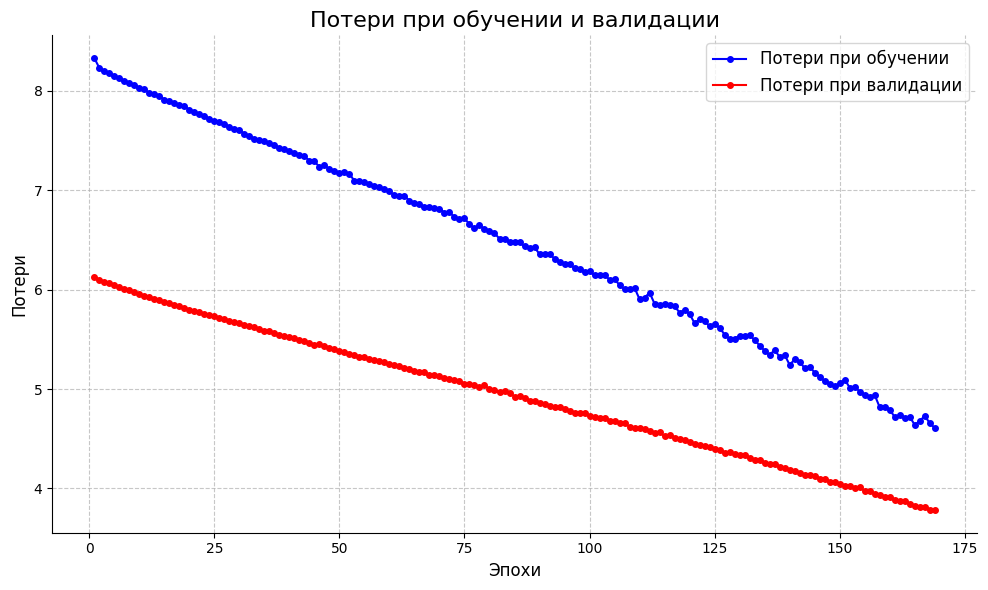

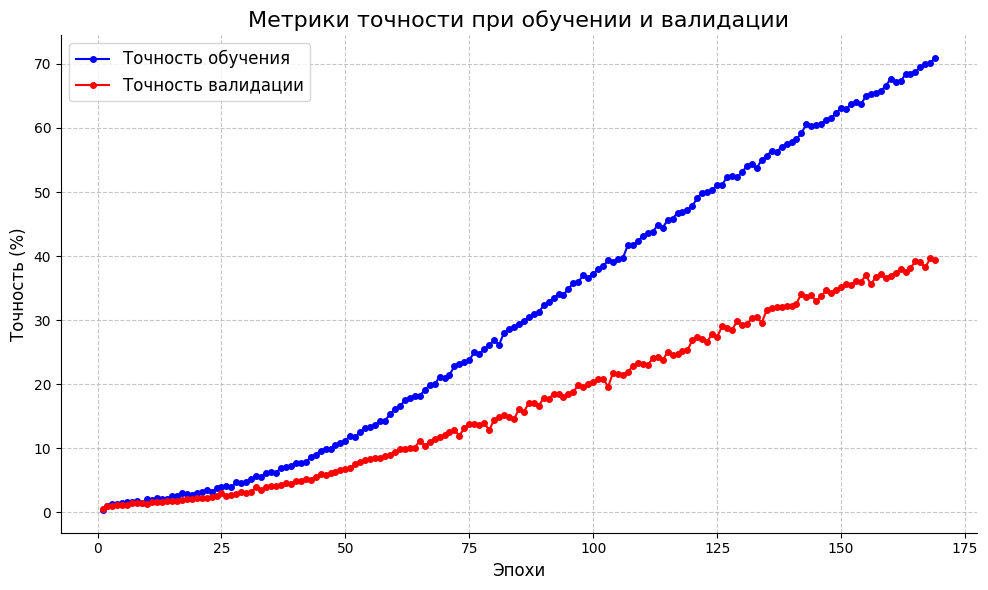

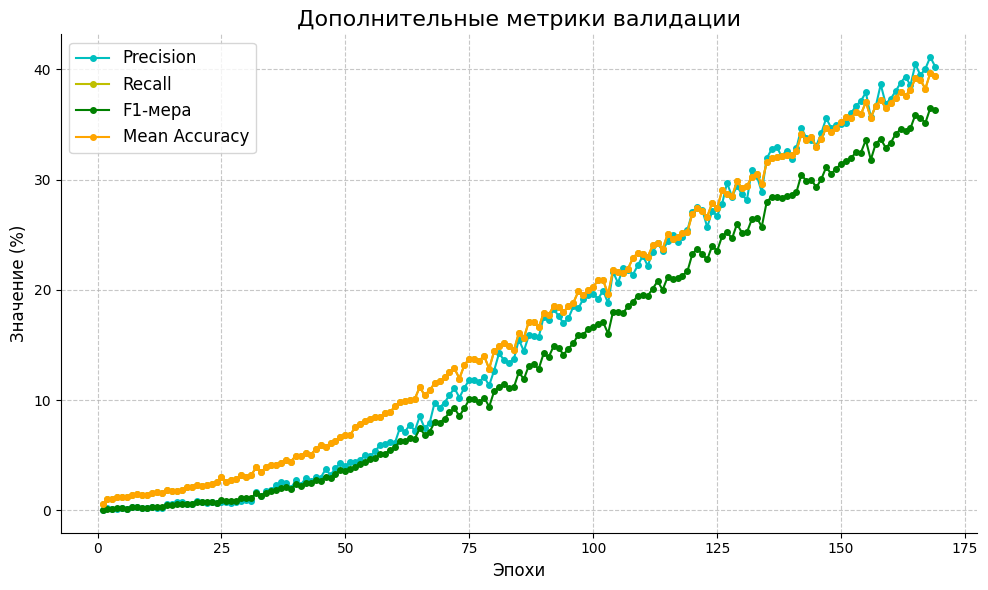

In [25]:
loss_fig, acc_fig,add_fig = plot_training_metrics(history, save_path='training_metrics')

In [26]:
results = analyze_training_results(history, best_val_acc, save_path='training_analysis.txt')


===== АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ =====
Всего эпох обучения: 169
Финальные потери при обучении: 4.6079
Финальная точность обучения: 70.96%
Финальные потери при валидации: 3.7841
Финальная точность валидации: 39.40%
Лучшая точность валидации: 3968.00%
Лучшая модель сохранена на эпохе: 168
Разрыв переобучения (обучение-валидация): 31.56%
Финальная точность (Precision): 40.24%
Финальная полнота (Recall): 39.40%
Финальная F1-мера: 36.30%
Лучшая F1-мера: 36.49% (эпоха 168)
Финальная средняя точность по классам: 39.40%
Лучшая средняя точность по классам: 39.68% (эпоха 168)
Анализ сохранен в training_analysis.txt


In [ ]:
print(f"\nОбучение завершено! Лучшая точность валидации: {best_val_acc:.2f}%")


Обучение завершено! Лучшая точность валидации: 3968.00%
